<a href="https://colab.research.google.com/github/SiciliaLeco/EyeGaze/blob/master/Normalized_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appearance-based Gaze Estimation (Feb 20)

dataset: MPIIGaze https://www.perceptualui.org/research/datasets/MPIIGaze/ 

CNN frame: LeNet 

### 1. Pre-processing data 

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from PIL import Image
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive 

To use COLAB, we should first connect to the drive then retreive the data.

In [ ]:
# Use google.colab to use drive dataset  
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/EyeGaze"
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Normalized', 'Normalized_process.ipynb']

In [ ]:
mat_files = glob.glob(path + '/Normalized/**/*.mat', recursive=True)
mat_files.sort()
print(mat_files)

['/content/drive/MyDrive/EyeGaze/Normalized/p00/day01.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day02.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day03.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day04.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day05.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day06.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day07.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day08.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day09.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day10.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day11.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day12.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day13.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day14.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day15.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day16.mat', '/content/drive/MyDrive/EyeGaze/Normalized/p00/day17.ma

In [ ]:
from scipy.io import loadmat
def read_eye_data(mat):
  '''
  read each mat file info 
  '''
  mat_data = loadmat(mat)
  right_info = mat_data['data']['right'][0, 0]
  gaze = right_info['gaze'][0, 0]
  image = right_info['image'][0, 0]
  pose = right_info['pose'][0, 0]
  return gaze, image, pose

def collect_data_from_mat(path):
  '''
  collect data from annotation part
  :param path: path of normalized data 
  :return:  list of index, image, pose, gaze
  '''
  mat_files = glob.glob(path + '/Normalized/**/*.mat', recursive = True)
  mat_files.sort()
  # dict to store
  gaze = list()
  image = list()
  index = list()
  pose = list()
  # X: image, head_pose 
  # y: gaze vector
  # index: pnum, pday
  for matfile in tqdm(mat_files):
    pnum = matfile.split('/')[-2]  # pxx
    pday = matfile.split('/')[-1].split('.')[0] # day0x
    index.append(pnum + '/' + pday)
    
    fgaze, fimage, fpose = read_eye_data(matfile)

    if gaze == []:
      gaze = fgaze
      image = fimage
      pose = fpose
    else:
      gaze = np.append(gaze, fgaze, axis = 0)
      image = np.append(image, fimage, axis = 0)
      pose = np.append(pose, fpose, axis = 0)

  return gaze, image, pose, index 

In [ ]:
gaze, image, pose, index = collect_data_from_mat(path)

100%|██████████| 521/521 [00:55<00:00,  9.40it/s]


In [ ]:
print("gaze vector shape")
print(gaze.shape)
print("pose vector shape")
print(pose.shape)
print("image vector shape")
print(image.shape)

gaze vector shape
(213658, 3)
pose vector shape
(213658, 3)
image vector shape
(213658, 36, 60)


From the above data processing, we can know the dimension and size of the vector.
Now the gaze vector and pose vector are all 3 dimension, while the eye image (we only process one eye in this training task) is a 36 * 60 pixels grey image.
I'll print an example of the data:

p00/day01
[-0.15190792  0.24172508  0.01848624]
[-0.12202543  0.09011014 -0.98842802]


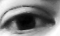

In [ ]:
idx = 0
print(index[idx])
print(pose[idx])
print(gaze[idx])
Image.fromarray(image[idx].reshape((36, 60)))

gaze(x, y, z) should be normalized 3D **vector** of the eye. x axis is parallel to the line that connects the midpoint of two eyes.
To simpify our CNN model, there's no need for us to use a 3D vector which might be more complicated, so the author just use two crutial angles to denote the gaze direction. 

pose(a, b, c) represents the rotation(**angle**) of the head. When dealing with the 3D transformation, the rotation matrix is usually used, but the rotation transformation actually only has three degrees of freedom, which is more concise when expressed in a rotation vector. Therefore, it is necessary to realize the mutual conversion between the rotation vector and the rotation matrix.

### 2. Dimension transformation
In this part, we should change pose and gaze vector from 3D to 2D. The suggested code is shown on the dataset website.

In [ ]:
import cv2 as cv
def pose3D_to_2D(pose):
  '''
    pose (a, b, c) is rotation (angle)
    M = Rodrigues((x,y,z))
    Zv = (the third column of M)
    theta = asin(Zv[1])
    phi = atan2(Zv[0], Zv[2])
  '''
  M, _ = cv.Rodrigues(np.array(pose).astype(np.float32))
  vec = M[:, 2]
  phi = np.arctan2(vec[0], vec[2])
  theta = np.arcsin(vec[1])
  return np.array([theta, phi])

def gaze3D_to_2D(gaze):
  '''
    gaze (x, y, z) is direction
    theta = asin(-y)
    phi = atan2(-x, -z)
  '''
  x, y, z = (gaze[i] for i in range(3))
  theta = np.arcsin(-y)
  phi = np.arctan2(-x, -z)
  return np.stack((theta, phi)).T

In [ ]:
pose2d = []
gaze2d = []
for i in np.arange(0, len(gaze), 1):
  pose2d.append(pose3D_to_2D(pose[i]))
  gaze2d.append(gaze3D_to_2D(gaze[i]))

poses = np.array(pose2d)
gazes = np.array(gaze2d)

In [ ]:
img_train, img_test, pose_train, pose_test, gaze_train, gaze_test = train_test_split(
    image, gazes, poses, test_size = 0.33, random_state = 0
)

In [ ]:
print(img_train[1])
print(img_test.shape)
print(pose_train[1])
print("training data size:",end="")
print(pose_train.shape[0])
print("test data size:", end="")
print(pose_test.shape[0])


[[255 255 254 ... 150 150 125]
 [254 254 254 ... 125  95  95]
 [254 254 254 ...  67  95  95]
 ...
 [250 250 250 ... 246 250 250]
 [250 250 246 ... 242 246 246]
 [252 252 246 ... 246 250 250]]
(70508, 36, 60)
[-0.30859049  0.16778534]
training data size:143150
test data size:70508


### 3. Muti-modal CNN

Use the LeNet framework.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        nn.init.constant_(module.bias, 0)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(3600, 500)  
        self.fc2 = nn.Linear(502, 2)

        self._initialize_weight()

    def _initialize_weight(self):
        nn.init.normal_(self.conv1.weight, mean=0, std=0.1)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.01)
        self.apply(initialize_weights)

    def forward(self, x, y):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = F.relu(self.fc1(x.view(x.size(0), -1)), inplace=True) #flatten        
        x = torch.cat([x, y], dim=1)
        x = self.fc2(x)
        return x

In [ ]:
GazeCNN = Model()

optimizer = torch.optim.Adam(GazeCNN.parameters(), lr=0.0001)
criterion = torch.nn.SmoothL1Loss(reduction='mean')

def batch_training(img, gaze, pose, j, bt):
  a = torch.randn(batch,1,36, 60)
  b = torch.randn(batch,2)
  c = torch.randn(batch,2)
  for i in range(batch):
    a[i, 0] = torch.tensor(img_train[j * bt + i])
    b[i] = torch.tensor(pose_train[j * bt + i])
    c[i] = torch.tensor(gaze_train[j * bt + i])
  return a, b, c

def batch_test(img, gaze, pose, j, bt):
  a = torch.randn(batch,1,36, 60)
  b = torch.randn(batch,2)
  c = torch.randn(batch,2)
  for i in range(batch):
    a[i, 0] = torch.tensor(img_test[j * bt + i])
    b[i] = torch.tensor(pose_test[j * bt + i])
    c[i] = torch.tensor(gaze_test[j * bt + i])
  return a, b, c


for epoch in range(3):
  batch = 10
  for i in tqdm(range(14315)):
  # training data 
    img = torch.randn(batch, 1, 36, 60)
    gaze = torch.randn(batch, 2)
    pose = torch.randn(batch, 2)
    img, gaze, pose = batch_training(img, gaze, pose, i, batch)

    gaze_pred = GazeCNN(img, pose)
    loss = criterion(gaze_pred, gaze)
    loss.backward()
    optimizer.step()

  timg, tgaze, tpose = batch_test(img, gaze, pose, 0, batch)
  gaze_pred = GazeCNN(timg, tpose)
  loss = criterion(gaze_pred, tgaze)
  print("epoch ", epoch, ", test loss:", loss)

  

  0%|          | 3/14315 [00:00<11:09, 21.37it/s]

epoch  0 , test loss: tensor(0.0090, grad_fn=<SmoothL1LossBackward>)


  0%|          | 2/14315 [00:00<12:19, 19.36it/s]

epoch  1 , test loss: tensor(0.0084, grad_fn=<SmoothL1LossBackward>)


100%|██████████| 14315/14315 [11:27<00:00, 20.82it/s]

epoch  2 , test loss: tensor(0.0075, grad_fn=<SmoothL1LossBackward>)


epoch  0 , test loss: tensor(0.0096, grad_fn=<SmoothL1LossBackward>)
epoch  1 , test loss: tensor(0.0109, grad_fn=<SmoothL1LossBackward>)
epoch  2 , test loss: tensor(0.0088, grad_fn=<SmoothL1LossBackward>)
epoch  3 , test loss: tensor(0.0078, grad_fn=<SmoothL1LossBackward>)
epoch  4 , test loss: tensor(0.0082, grad_fn=<SmoothL1LossBackward>)

> Indented block



100%|██████████| 14315/14315 [11:25<00:00, 20.89it/s]
  0%|          | 3/14315 [00:00<10:48, 22.07it/s]epoch  0 , test loss: tensor(0.0099, grad_fn=<SmoothL1LossBackward>)
100%|██████████| 14315/14315 [10:59<00:00, 21.72it/s]
  0%|          | 3/14315 [00:00<11:02, 21.60it/s]epoch  1 , test loss: tensor(0.0086, grad_fn=<SmoothL1LossBackward>)
100%|██████████| 14315/14315 [10:59<00:00, 21.69it/s]
  0%|          | 3/14315 [00:00<11:02, 21.59it/s]epoch  2 , test loss: tensor(0.0082, grad_fn=<SmoothL1LossBackward>)
100%|██████████| 14315/14315 [11:05<00:00, 21.50it/s]
  0%|          | 3/14315 [00:00<11:36, 20.56it/s]epoch  3 , test loss: tensor(0.0077, grad_fn=<SmoothL1LossBackward>)
100%|██████████| 14315/14315 [11:02<00:00, 21.62it/s]
epoch  4 , test loss: tensor(0.0080, grad_fn=<SmoothL1LossBackward>)

In [ ]:
test_loss = 0
for i in tqdm(range(3000)):
  timg, tgaze, tpose = batch_test(img, gaze, pose, i, batch)
  gaze_pred = GazeCNN(timg, tpose)
  test_loss += criterion(gaze_pred, tgaze)

print(test_loss / 3000)

100%|██████████| 3000/3000 [01:02<00:00, 48.18it/s]

tensor(0.0081, grad_fn=<DivBackward0>)


probLems:
1. server crashed when processing test datasets

2. measurement on loss/ accuracy -- how to judge my model


### References
1. https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild

2. Y. Sugano, Y. Matsushita, and Y. Sato. Learning-by-synthesis for appearance-based 3d gaze estimation. In Computer Vision and Pattern Recognition (CVPR), 2014 IEEE Conference on, pages 1821–1828. IEEE, 2014.

3. 
